# Optm  
.

In [1]:
# load libraries
import csv
import matplotlib.pyplot as plt
import multiprocessing as mp 
import numpy as np
import scipy.io as sio
import scipy.stats as stat
import zipfile
from tvb.simulator.plot.tools import *
from tvb.simulator.lab import *
from tvb.contrib.scripts.models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI

LOG = get_logger('BBt')

2022-02-22 22:59:34,038 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


In [2]:
import os
import pandas as pd
print(pd.__version__)

1.4.0


## Introduction  
a

## Load files 
Put Input data folder in the same directory of this python notebook.
Input data needs to follow the directory structure below:
```
TVB_bbt.ipynb
StaticOptimization.xlsx
TVB_input
│   CONXXTX (Control/Patients + number + T1/T2)
│   │   FC.mat
│   │   SCthrAn.mat
│   └───CON02T1_TVB.zip
│       │   areas.txt
│       │   average_orientations.txt
│       │   centres.txt
│       │   cortical.txt
│       │   hemisphere.txt
│       │   tract_lengths.txt.txt
│       │   weights.txt
│   
└───CONXXTX
    ```

# Reading from OpenSim 
Reading data from OpenSim. 

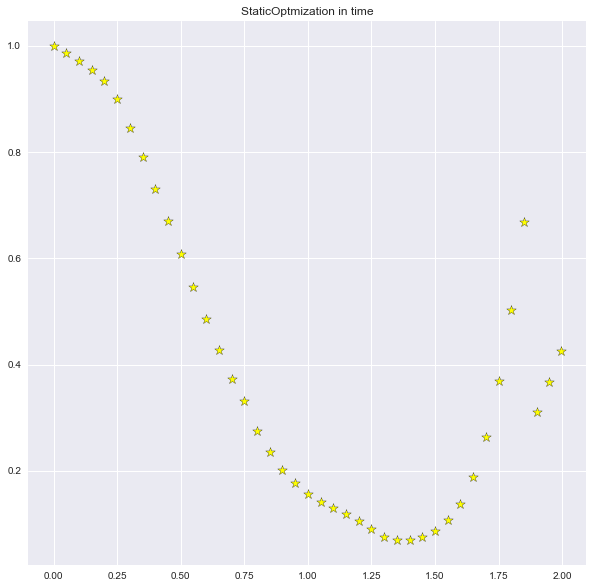

In [3]:
# Set directory path
data_dir = os.path.abspath("TVB_input")
zip_suffix = "_TVB"
var = pd.read_excel('StaticOptimization.xlsx', index_col=1)
''' print(var) '''
x = list(var['X'])
y = list(var['Ynorm'])
plt.figure(figsize=(10,10))
plt.style.use('seaborn')
plt.scatter(x,y,marker="*",s=100,edgecolors="black",c="yellow")
plt.title("StaticOptmization in time")
plt.show()

#Alex: Determinar cómo sé si tengo activación? 
#(Numéricamente qué tiene qué pasar en los datos? Derivada>"x" durante 3 T_sampling???)
activation = True #for the moment

# Build Stimulus
Building stimulus as result of reading OpenSim data of an activation.
The Stimulus will be defined as a Delta train and arbitrary parameters. 


According to the study by Yuan et al. [1], hand, wrist and arm movement cover the position of C3 and C4 to the center of scalp. Accordingly, apart from the positions of C3, Cz and C4 that are on the area, the adjacent positions which are F3, Fz, F4, P3, Pz, P4, T7 and T8 are also chosen. [1]: https://doi.org/10.1186/s12938-018-0534-0

In TVB's connectivity demo dataset region 5 and 6 represent areas of C3 and C4. (https://github.com/the-virtual-brain/tvb-data/blob/master/tvb_data/sensors/eeg_brainstorm_65.txt)

WARNING  File 'hemispheres' not found in ZIP.


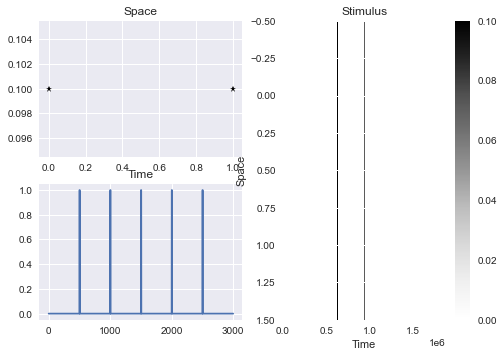

In [4]:
#define Stimuli equation 
eqn_t = equations.PulseTrain()
eqn_t.parameters["onset"] = 500.0 # ms
eqn_t.parameters["tau"]   = 5.0   # ms
eqn_t.parameters["T"]     = 500.  # 0.002kHz repetition frequency

#define weights
nodes = [5, 8] #C3 and P3
stim_weights = numpy.zeros((76, ))
stim_weights[nodes] = 0.1

#define connectivity
conn = connectivity.Connectivity.from_file()
conn_coupling = coupling.Linear(a=numpy.array([0.042]))
conn.configure()

#build stimulus if imported data from OpenSim shows an activation


if(activation):
    stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                  connectivity = conn, 
                                  weight = stim_weights)
    stimulus.configure_space((nodes))
    stimulus.configure_time(numpy.arange(0e3, 3e3, 5**-4)) #start, finish, 
    plot_pattern(stimulus)

# Simulation
Simulation in an arbitrary Connectivity (default) and an arbitrary Conditions.

In [5]:
import tvb.datatypes.projections as projections

conn = connectivity.Connectivity.from_file()
conn_coupling = coupling.Linear(a=numpy.array([0.042]))


mod = models.Generic2dOscillator(a=numpy.array([-0.5]), b=numpy.array([-15.0]), c=numpy.array([0.0]), d=numpy.array([0.02]))

hiss    = noise.Additive(nsig = numpy.array([0.015]))
heunint = integrators.HeunStochastic(dt=2**-6, noise=hiss)

conn.configure()
nodes = [5, 8] #C3 and P3
stim_weights = numpy.zeros((conn.number_of_regions, 1))
stim_weights[nodes] = numpy.array([3.5, 0.0])[:, numpy.newaxis]
eqn_t = equations.PulseTrain()


eqn_t.parameters["onset"] = 500.0 # ms
eqn_t.parameters["tau"]   = 5.0   # ms
eqn_t.parameters["T"]     = 500.  # 0.002kHz repetition frequency

stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                  connectivity = conn, 
                                  weight = stim_weights)
    
    
pr = projections.ProjectionSurfaceEEG.from_file()
ss = sensors.SensorsEEG.from_file(source_file="eeg_brainstorm_65.txt")
rm = region_mapping.RegionMapping.from_file()

rec = (monitors.TemporalAverage(period=1e3 / 2048.), 
       monitors.EEG(projection=pr, sensors=ss, region_mapping=rm, period=1e3/2048.))

def config_sim(stim=None):
    sim = simulator.Simulator(model = mod, 
                          connectivity = conn,
                          coupling = conn_coupling, 
                          integrator = heunint, 
                          monitors = rec,
                          stimulus = stim)
                    
    sim.configure()
    return sim

def run_simulation(sim):
    #Perform the simulation
    tavg_data = []
    tavg_time = []
    eeg_data = []
    eeg_time = []
    for tavg, eeg in sim(simulation_length=2**10):
    # approx 4 sec
        if not tavg is None:
            tavg_time.append(tavg[0])
            tavg_data.append(tavg[1])
            
        if not eeg is None:
            eeg_time.append(eeg[0])
            eeg_data.append(eeg[1])
            
    return (tavg_data, tavg_time, eeg_data, eeg_time)


WARNING  File 'hemispheres' not found in ZIP.


In [6]:
import tvb.datatypes.projections as projections
pr = projections.ProjectionSurfaceEEG.from_file()
ss = sensors.SensorsEEG.from_file(source_file="eeg_brainstorm_65.txt")
rm = region_mapping.RegionMapping.from_file()

rec = (monitors.TemporalAverage(period=1e3 / 2048.), 
       monitors.EEG(projection=pr, sensors=ss, region_mapping=rm, period=1e3/2048.))

# Plot of results
We plot the results of the simulation where should be seen 2 different situations:
1) First using the simulation without the Stimulus;
2) Second, using the Stimulus in the simulation

   INFO  Projection configured gain shape (65, 76)


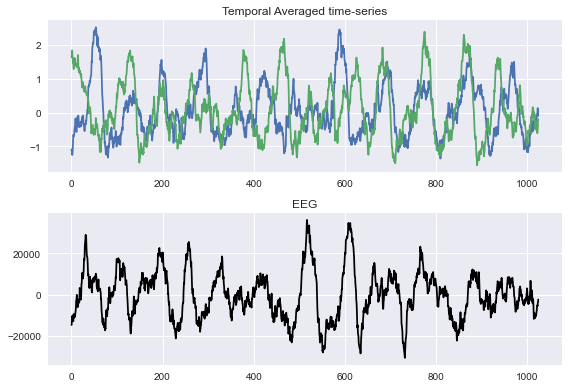

In [7]:
sim = config_sim()
out = run_simulation(sim) 

TAVG = numpy.array(out[0]) #tavg_data
tt   = numpy.array(out[1]) #tavg_time
EEG  = numpy.array(out[2]) #eeg_data

plt.show()

plt.subplot(2,1,1)
plt.plot(tt, TAVG[:, 0, nodes, 0])
plt.title("Temporal Averaged time-series")

plt.subplot(2,1,2)
plt.plot(tt, EEG[:, 0, 60, 0], 'k')
plt.title("EEG")

plt.tight_layout()

The following is Results taking the Stimulus into account

   INFO  Projection configured gain shape (65, 76)


Text(0.5, 1.0, 'Stim - EEG')

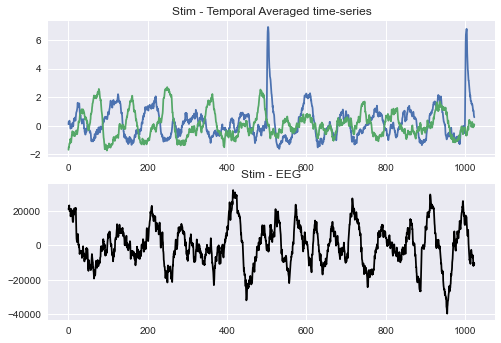

In [8]:
sim = config_sim(stim=stimulus)
stout = run_simulation(sim)

STAVG = numpy.array(stout[0])
stt   = numpy.array(stout[1])
SEEG  = numpy.array(stout[2])

plt.figure()

plt.subplot(2,1,1)
plt.plot(stt, STAVG[:, 0, nodes, 0])
plt.title("Stim - Temporal Averaged time-series")

plt.subplot(2,1,2)
plt.plot(stt, SEEG[:, 0, 60, 0], 'k')
plt.title("Stim - EEG")

# Output of movement
Out of the previous plot, we build a novel vector which translates simulated EEG activations into a simple vector made of binary symbols.

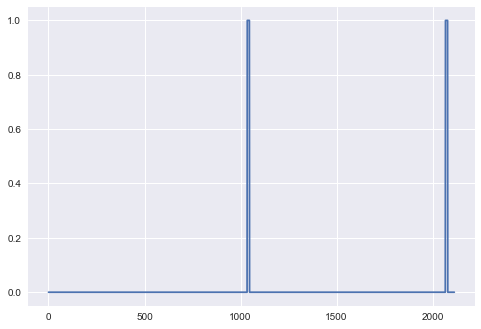

In [9]:
nodes = [5, 8]
Treshold = 4;
vector_Stim=numpy.zeros(len(STAVG))
for i in range(len(STAVG)):
    if STAVG[i, 0, 5, 0]>=Treshold:
        #print('1')
        vector_Stim[i]=1
        
    elif STAVG[i, 0, 8, 0]>=Treshold:
        #print('2')
        vector_Stim[i]=2
    else:
        a=1
        vector_Stim[i]=0
plt.plot(vector_Stim)

In [10]:
len(STAVG)

2114

In [11]:
file = open("Activation-Vector", "w")
file.write("Vector (1 act; 0 no act)" + os.linesep)
file.write(str(vector_Stim))
file.close()

In [17]:
import pandas as pd

## convert your array into a dataframe
df = pd.DataFrame (array)

## save to xlsx file

filepath = 'my_excel_file.xlsx'

df.to_excel(filepath, index=False)

ValueError: No engine for filetype: ''